In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from prophet import Prophet


from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/Users/farhan/anaconda3/envs/timeseries/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
pjme = pd.read_csv('Dataset/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


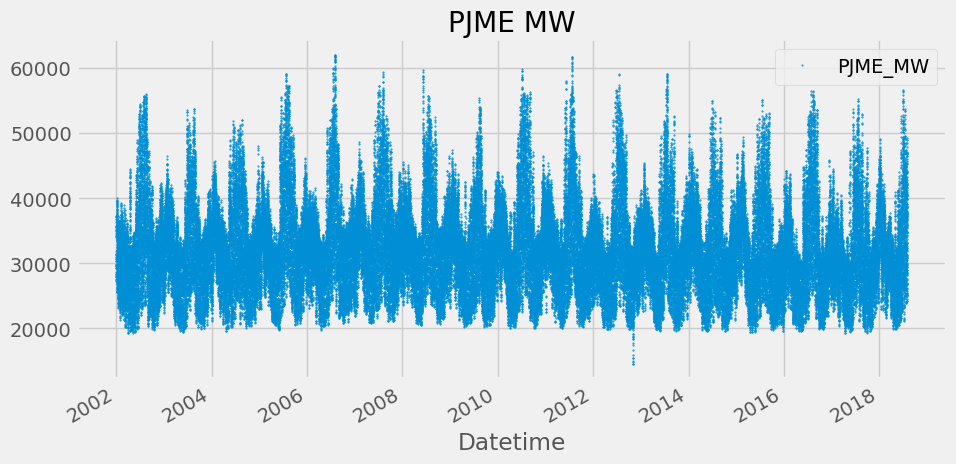

In [3]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [4]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

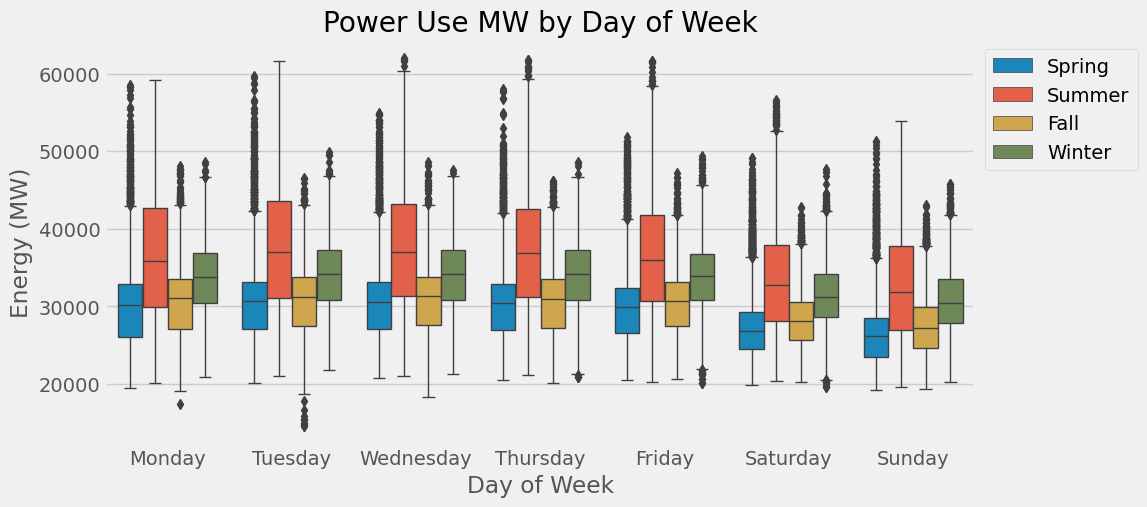

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

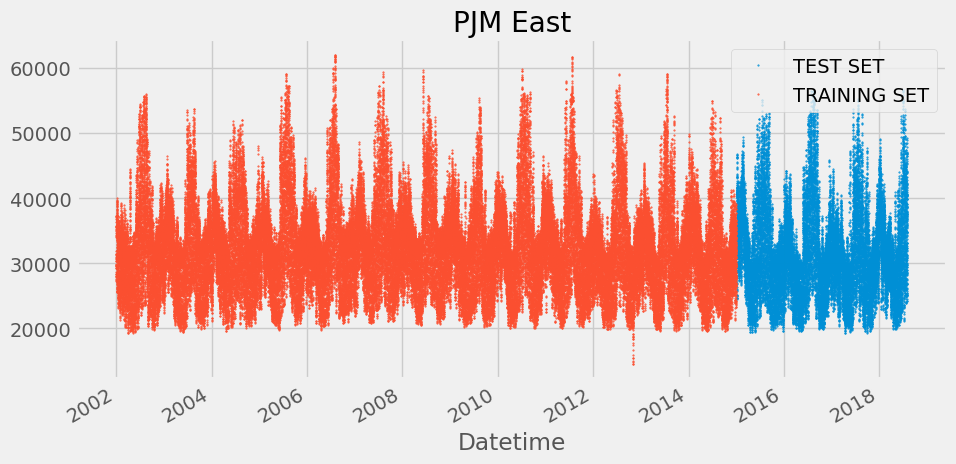

In [6]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [7]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [8]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

15:49:36 - cmdstanpy - INFO - Chain [1] start processing
15:50:01 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.15 s, sys: 178 ms, total: 3.33 s
Wall time: 28.2 s


In [9]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [10]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31196.970537,23706.719270,32931.660720,31196.970537,31196.970537,-2850.988344,-2850.988344,-2850.988344,-4430.274562,...,1281.383404,1281.383404,1281.383404,297.902815,297.902815,297.902815,0.0,0.0,0.0,28345.982193
1,2015-01-01 02:00:00,31196.931818,22249.950536,31156.670856,31196.931818,31196.931818,-4355.316666,-4355.316666,-4355.316666,-5927.136225,...,1272.626765,1272.626765,1272.626765,299.192794,299.192794,299.192794,0.0,0.0,0.0,26841.615151
2,2015-01-01 03:00:00,31196.893099,21650.071967,30269.453378,31196.893099,31196.893099,-5227.032103,-5227.032103,-5227.032103,-6790.220743,...,1262.664360,1262.664360,1262.664360,300.524280,300.524280,300.524280,0.0,0.0,0.0,25969.860996
3,2015-01-01 04:00:00,31196.854380,21262.861798,30417.380502,31196.854380,31196.854380,-5368.660011,-5368.660011,-5368.660011,-6922.177063,...,1251.619752,1251.619752,1251.619752,301.897299,301.897299,301.897299,0.0,0.0,0.0,25828.194369
4,2015-01-01 05:00:00,31196.815661,22166.319956,31133.156686,31196.815661,31196.815661,-4694.407605,-4694.407605,-4694.407605,-6237.348194,...,1239.628713,1239.628713,1239.628713,303.311876,303.311876,303.311876,0.0,0.0,0.0,26502.408056


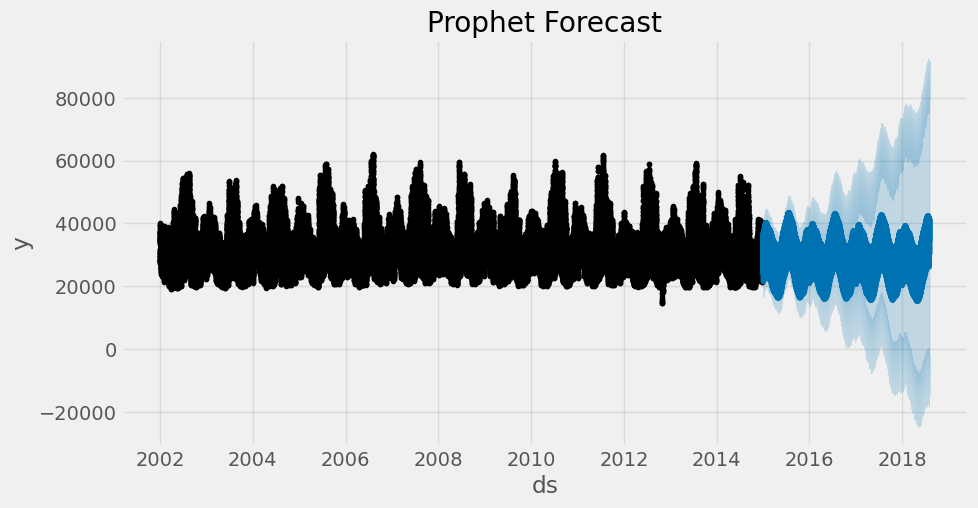

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

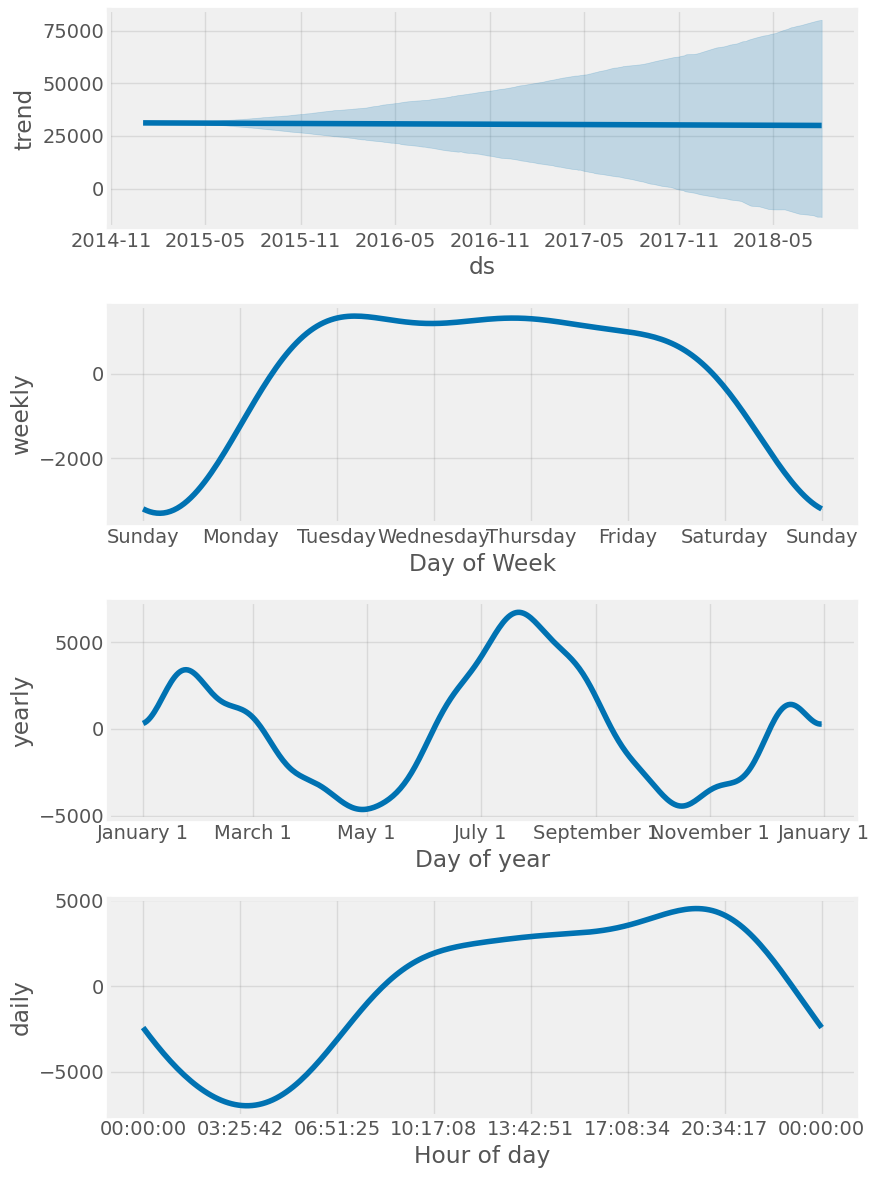

In [12]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

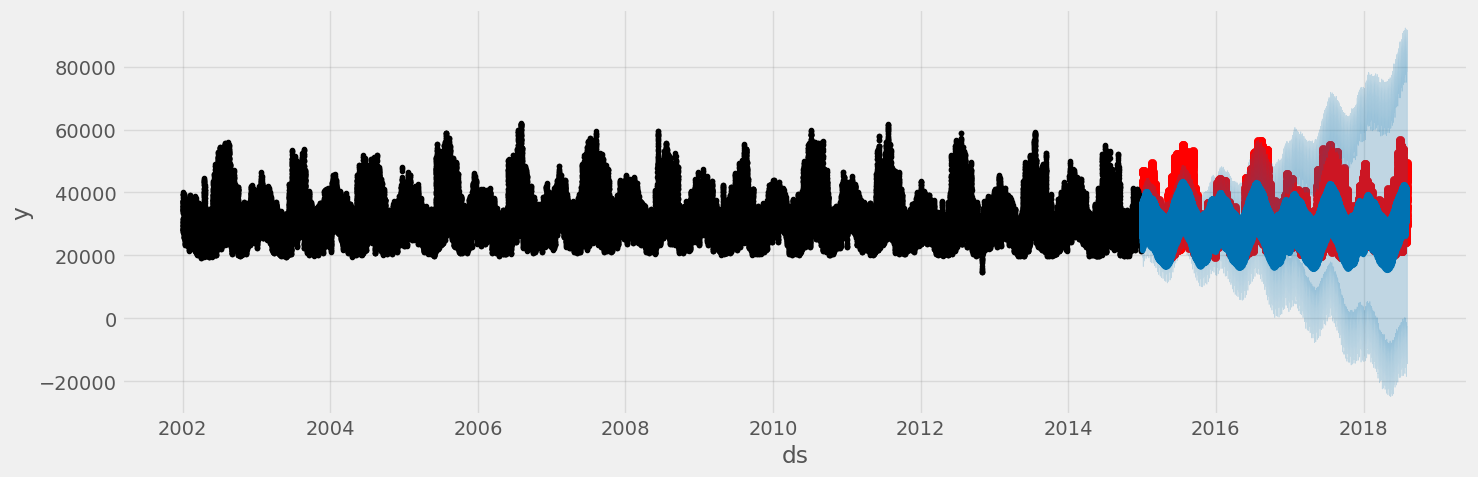

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

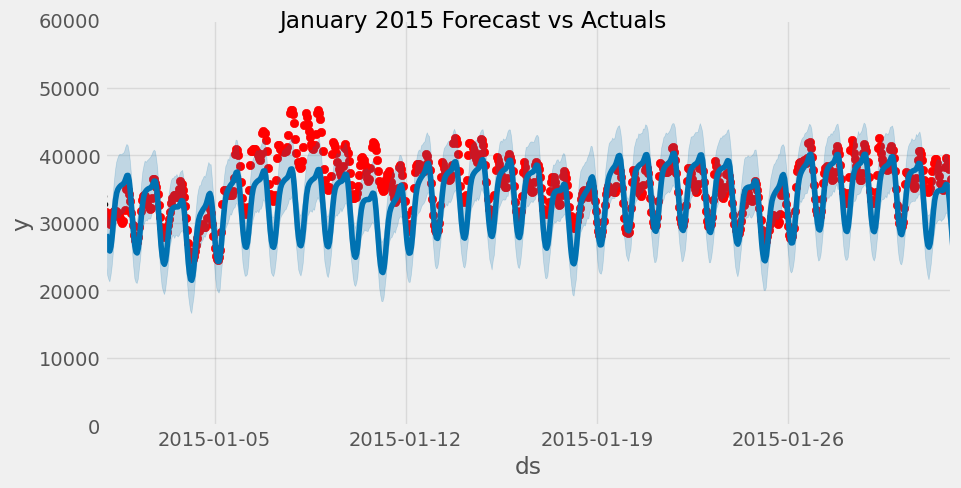

In [14]:
import datetime  # Make sure to import the datetime module

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert string dates to datetime objects
lower_bound = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
upper_bound = datetime.datetime.strptime('02-01-2015', '%m-%d-%Y')

# Apply the datetime objects to set_xbound
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')


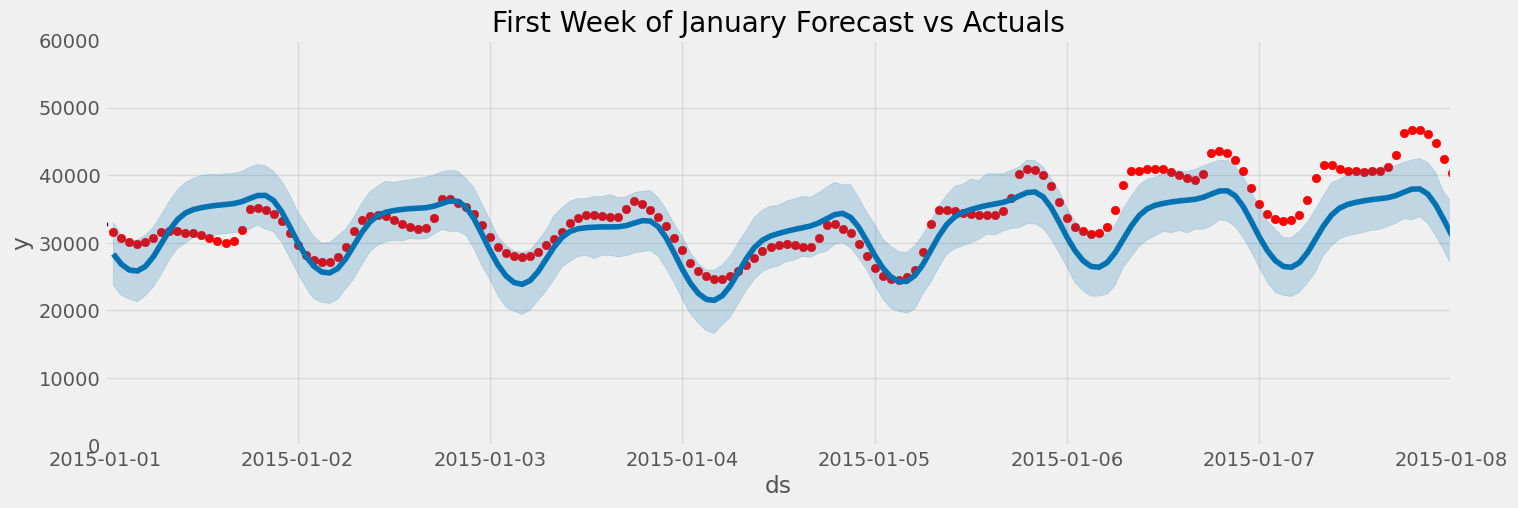

In [15]:
# Assuming pjme_test.index is already in datetime format
# If not, convert it:
# pjme_test.index = pd.to_datetime(pjme_test.index)

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert string dates to datetime objects for the x-axis bounds
lower_bound = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
upper_bound = datetime.datetime.strptime('01-08-2015', '%m-%d-%Y')

# Apply the datetime objects to set_xbound
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()


# Evaluate the model with Error Metrics

In [16]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6620.642498035235

In [17]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5183.987588681759

In [18]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.505729454071584

# Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [19]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model.predict(future)

In [20]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,28345.982193
1,2015-01-01 02:00:00,26841.615151
2,2015-01-01 03:00:00,25969.860996
3,2015-01-01 04:00:00,25828.194369
4,2015-01-01 05:00:00,26502.408056
